<a href="https://colab.research.google.com/github/ucaokylong/LLM_learning/blob/main/Multimodal_model_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caoklong","key":"9a5b65b8df67163d613d61278cda07ca"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
 ! kaggle datasets list

ref                                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                      9KB  2024-08-17 06:57:57           2926         70  0.9411765        
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                           1KB  2024-08-14 11:02:45           3080         56  1.0              
haseebindata/global-population-growth-2024                           Global Population Growth 2024                       20KB  2024-08-21 05:32:16            946         22  0.88235295       
balajivaraprasad/crimes-against-women-in

In [10]:
! kaggle datasets download -d hsankesara/flickr-image-dataset

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.14G/8.16G [00:58<00:00, 219MB/s]
100% 8.16G/8.16G [00:58<00:00, 149MB/s]


In [11]:
!unzip /content/flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [14]:
!rm /content/flickr-image-dataset.zip

In [15]:
!pip -q install sentence-transformers
!pip -q install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.1 MB/s eta 0:00:00


In [17]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


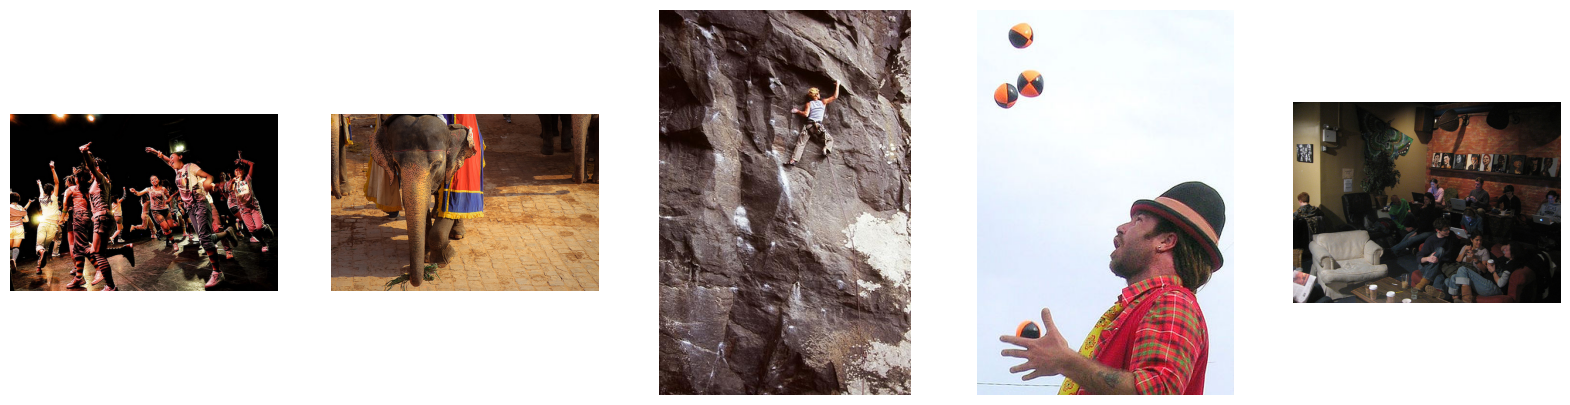

In [21]:
image_folder = "/content/flickr30k_images/flickr30k_images"

image_files = glob(os.path.join(image_folder,"*.jpg"))

selected_images = random.sample(image_files,5)
plt.figure(figsize=(20, 5))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [38]:
# Tao embedding cho 30K anh bang model
model = SentenceTransformer('clip-ViT-B-32')
image_path = "/content/flickr30k_images/flickr30k_images"

image_files = glob(os.path.join(image_path,"*.jpg"))
chunk_size = 512
embeddings = []

def process_chunk(chunk):
  images = []
  for image_file in chunk:
    image = Image.open(image_file)
    images.append(image)

  chunk_embeddings = model.encode(images)
  return chunk_embeddings

for i in range(0, len(image_files), chunk_size):
  print(i)
  chunk = image_files[i:i+chunk_size]
  chunk_embeddings = process_chunk(chunk)
  embeddings.extend(chunk_embeddings)



0
512
1024
1536
2048
2560
3072
3584
4096
4608
5120
5632
6144
6656
7168
7680
8192
8704
9216
9728
10240
10752
11264
11776
12288
12800
13312
13824
14336
14848
15360
15872
16384
16896
17408
17920
18432
18944
19456
19968
20480
20992
21504
22016
22528
23040
23552
24064
24576
25088
25600
26112
26624
27136
27648
28160
28672
29184
29696
30208
30720
31232
31744


In [39]:
dimension = len(embeddings[0])
index = faiss.IndexFlatIP(dimension)
index = faiss.IndexIDMap(index)

vectors = np.array(embeddings).astype('float32')
index.add_with_ids(vectors, np.array(range(len(embeddings))))

faiss.write_index(index, 'index.faiss')

with open("image_files.txt", "w") as file:
    for image_file in image_files:
        file.write(image_file + "\n")

In [43]:
def search_image(query, model, index, image_files, top_k=5):

  if query.endswith(".jpg"):
    query_image = Image.open(query)

  query_embedding = model.encode(query)
  query_embedding = query_embedding.astype('float32').reshape(1, -1)


  distances, indices = index.search(query_embedding, top_k)

  retrieved_image_files = [image_files[i] for i in indices[0]]
  return query, retrieved_image_files





In [47]:
query = "a man crying and drive a bike"
query, retrieved_image_files = search_image(query, model, index, image_files)

In [45]:
def visualize_results(query, retrieved_images):
  plt.figure(figsize=(12, 5))

  if isinstance(query, Image.Image):
    plt.subplot(1, len(retrieved_image_files) + 1, 1)
    plt.imshow(query)
    plt.title("Query Image")
    plt.axis('off')
    start_idx = 2

  else:
    plt.subplot(1, len(retrieved_image_files) + 1, 1)
    plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha = 'center', va='center')
    plt.axis('off')
    start_idx = 2

  for i, img_path in enumerate(retrieved_images):

    plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f"Match {i + 1}")
    plt.axis('off')
  plt.show()

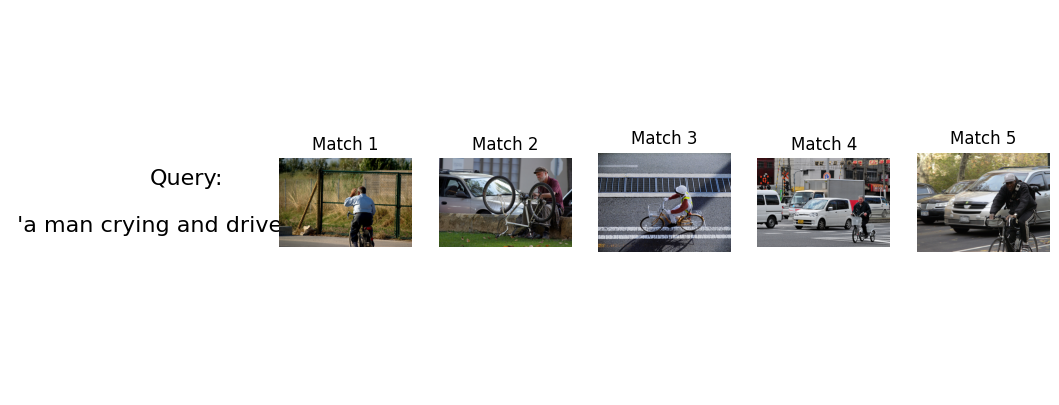

In [48]:
visualize_results(query, retrieved_image_files)